## Imports

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten ,MaxPooling2D, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import re

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.clear_session()

## Functions

In [3]:
# extract prefix to group by participant insted of trip
def extract_prefix(filename):
    # split filename on '_' 
    return re.split(r'_', filename)[0]

# create sequences of consecutive intrevales 
def create_sequences(data, labels, filenames, window_size):
    # vars to store the sequences and the respective labels
    sequences = []
    sequence_labels = []
    
    # get the file name to filter by participant
    current_prefix = extract_prefix(filenames[0])
    current_sequence = []
    current_labels = []
    
    # loop all intrevals
    for i in range(len(data)):
        # get current filename
        prefix = extract_prefix(filenames[i])
        
        # if the intreval belongs to diferent participant reset the sequences and vars
        if prefix != current_prefix:
            current_prefix = prefix
            current_sequence = [] 
            current_labels = []

        # add the intrevlal and the label to the current sequence
        current_sequence.append(data[i])
        current_labels.append(labels[i])
        
        # check if the sequence reach the max size and if so, store the sequence and the lable
        if len(current_sequence) == window_size:
            sequences.append(current_sequence.copy()) 
            sequence_labels.append(current_labels[-1]) 
            current_sequence.pop(0)

    return np.array(sequences), np.array(sequence_labels)

## Data Pre-Processing

In [4]:
# get data
file_path_1 = '../pre_process_2/datasets_v2/supervised_1_min.csv'
file_path_2 = '../pre_process_2/datasets_v2/supervised_2_min.csv'
file_path_3 = '../pre_process_2/datasets_v2/supervised_3_min.csv'
file_path_5 = '../pre_process_2/datasets_v2/supervised_5_min.csv'
file_path_8 = '../pre_process_2/datasets_v2/supervised_8_min.csv'

df_1_min = pd.read_csv(file_path_1, delimiter=',')
df_2_min = pd.read_csv(file_path_2, delimiter=',')
df_3_min = pd.read_csv(file_path_3, delimiter=',')
df_5_min = pd.read_csv(file_path_5, delimiter=',')
df_8_min = pd.read_csv(file_path_8, delimiter=',')


# filenames with the "pvt recording"
filenames_to_remove = [
    "fp01_2.edf", "fp01_4.edf", "fp02_1.edf", "fp02_2.edf", "fp02_4.edf",
    "fp03_1.edf", "fp03_2.edf", "fp04_1.edf", "fp05_1.edf", "fp06_1.edf",
    "fp07_1.edf", "fp08_1.edf", "fp09_1.edf", "fp10_1.edf", "fp11_1.edf",
    "fp12_1.edf", "fp13_1.edf", "fp14_1.edf", "fp14_3.edf", "fp15_1.edf",
    "fp16_1.edf", "fp17_1.edf", "fp17_2.edf", "fp17_4.edf", "fp18_1.edf",
    "fp18_2.edf", "fp19_1.edf", "fp19_3.edf", "fp19_4.edf", "fp20_1.edf", 
    "fp20_3.edf"
]

# remove the unwanted instances from the dfs
df_1_min = df_1_min[~df_1_min['Filename'].isin(filenames_to_remove)]
df_2_min = df_2_min[~df_2_min['Filename'].isin(filenames_to_remove)]
df_3_min = df_3_min[~df_3_min['Filename'].isin(filenames_to_remove)]
df_5_min = df_5_min[~df_5_min['Filename'].isin(filenames_to_remove)]
df_8_min = df_8_min[~df_8_min['Filename'].isin(filenames_to_remove)]

# remove columns with null values
df_1_min = df_1_min[(df_1_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_2_min = df_2_min[(df_2_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_3_min = df_3_min[(df_3_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_5_min = df_5_min[(df_5_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_8_min = df_8_min[(df_8_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]

# remove missing values
df_1_min = df_1_min.dropna()
df_2_min = df_2_min.dropna()
df_3_min = df_3_min.dropna()
df_5_min = df_5_min.dropna()
df_8_min = df_8_min.dropna()

# get wanted features for training data
df_features_1_min = df_1_min[(df_1_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_2_min = df_2_min[(df_2_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_3_min = df_3_min[(df_3_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_5_min = df_5_min[(df_5_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_8_min = df_8_min[(df_8_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]

# final wanted features
features_1_min = df_features_1_min.columns.to_list()
features_2_min = df_features_2_min.columns.to_list()
features_3_min = df_features_3_min.columns.to_list()
features_5_min = df_features_5_min.columns.to_list()
features_8_min = df_features_8_min.columns.to_list()

### Normalization

In [ ]:
# normalize data
scaler = StandardScaler()
X_scaled_1_min = scaler.fit_transform(df_1_min[features_1_min].values)
X_scaled_2_min = scaler.fit_transform(df_2_min[features_2_min].values)
X_scaled_3_min = scaler.fit_transform(df_3_min[features_3_min].values)
X_scaled_5_min = scaler.fit_transform(df_5_min[features_5_min].values)
X_scaled_8_min = scaler.fit_transform(df_8_min[features_8_min].values)

### Descretrization

In [6]:
# descretize the value of KSS
labels_1_min = (df_1_min['kss_answer'] > 6).astype(int)
labels_2_min = (df_2_min['kss_answer'] > 6).astype(int)
labels_3_min = (df_3_min['kss_answer'] > 6).astype(int)
labels_5_min = (df_5_min['kss_answer'] > 6).astype(int)
labels_8_min = (df_8_min['kss_answer'] > 6).astype(int)

### Prepare data to train the model

In [ ]:
# get all filenames
filenames_1_min = df_1_min['Filename'].values
filenames_2_min = df_2_min['Filename'].values
filenames_3_min = df_3_min['Filename'].values
filenames_5_min = df_5_min['Filename'].values
filenames_8_min = df_8_min['Filename'].values

# number of intrevlas in sequence
window_size = 10

# create sequences and respective lables
X_sequences_1_min, y_sequences_1_min = create_sequences(X_scaled_1_min, labels_1_min.values, filenames_1_min, window_size)
X_sequences_2_min, y_sequences_2_min = create_sequences(X_scaled_2_min, labels_2_min.values, filenames_2_min, window_size)
X_sequences_3_min, y_sequences_3_min = create_sequences(X_scaled_3_min, labels_3_min.values, filenames_3_min, window_size)
X_sequences_5_min, y_sequences_5_min = create_sequences(X_scaled_5_min, labels_5_min.values, filenames_5_min, window_size)
X_sequences_8_min, y_sequences_8_min = create_sequences(X_scaled_8_min, labels_8_min.values, filenames_8_min, window_size)

# verify shape of sequences
print("Shape of X_sequences of 1 Min :", X_sequences_1_min.shape)
print("Shape of y_sequences of 1 Min:", X_sequences_1_min.shape)
print("Shape of X_sequences of 2 Min :", X_sequences_2_min.shape)
print("Shape of y_sequences of 2 Min:", X_sequences_2_min.shape)
print("Shape of X_sequences of 3 Min :", X_sequences_3_min.shape)
print("Shape of y_sequences of 3 Min:", X_sequences_3_min.shape)
print("Shape of X_sequences of 5 Min :", X_sequences_5_min.shape)
print("Shape of y_sequences of 5 Min:", X_sequences_5_min.shape)
print("Shape of X_sequences of 8 Min :", X_sequences_8_min.shape)
print("Shape of y_sequences of 8 Min:", X_sequences_8_min.shape)

# test and train data split
X_train_1_min, X_test_1_min, y_train_1_min, y_test_1_min = train_test_split(X_sequences_1_min, y_sequences_1_min, test_size=0.20, random_state=42)
X_train_2_min, X_test_2_min, y_train_2_min, y_test_2_min = train_test_split(X_sequences_2_min, y_sequences_2_min, test_size=0.20, random_state=42)
X_train_3_min, X_test_3_min, y_train_3_min, y_test_3_min = train_test_split(X_sequences_3_min, y_sequences_3_min, test_size=0.20, random_state=42)
X_train_5_min, X_test_5_min, y_train_5_min, y_test_5_min = train_test_split(X_sequences_5_min, y_sequences_5_min, test_size=0.20, random_state=42)
X_train_8_min, X_test_8_min, y_train_8_min, y_test_8_min = train_test_split(X_sequences_8_min, y_sequences_8_min, test_size=0.20, random_state=42)

Shape of X_sequences of 1 Min : (4174, 10, 27)
Shape of y_sequences of 1 Min: (4174, 10, 27)
Shape of X_sequences of 2 Min : (1987, 10, 27)
Shape of y_sequences of 2 Min: (1987, 10, 27)
Shape of X_sequences of 3 Min : (1254, 10, 27)
Shape of y_sequences of 3 Min: (1254, 10, 27)
Shape of X_sequences of 5 Min : (667, 10, 27)
Shape of y_sequences of 5 Min: (667, 10, 27)
Shape of X_sequences of 8 Min : (347, 10, 27)
Shape of y_sequences of 8 Min: (347, 10, 27)


### Create LSTM Models

In [ ]:
# clear the current session to reset the model and optimizer state
K.clear_session()

# define LSTM Model for 1 min
model_1_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_1_min.shape[1], X_train_1_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_1_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define LSTM Model for 1 min
model_2_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_2_min.shape[1], X_train_2_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_2_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define LSTM Model for 1 min
model_3_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_3_min.shape[1], X_train_3_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_3_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define LSTM Model for 1 min
model_5_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_5_min.shape[1], X_train_5_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_5_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define LSTM Model for 1 min
model_8_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_8_min.shape[1], X_train_8_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_8_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### Models Training

In [16]:
# train models
history_1_min = model_1_min.fit(X_train_1_min, y_train_1_min, epochs=200, batch_size=32, validation_split=0.2)
history_2_min = model_2_min.fit(X_train_2_min, y_train_2_min, epochs=200, batch_size=32, validation_split=0.2)
history_3_min = model_3_min.fit(X_train_3_min, y_train_3_min, epochs=200, batch_size=32, validation_split=0.2)
history_5_min = model_5_min.fit(X_train_5_min, y_train_5_min, epochs=200, batch_size=32, validation_split=0.2)
history_8_min = model_8_min.fit(X_train_8_min, y_train_8_min, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6363 - loss: 0.6465 - val_accuracy: 0.7111 - val_loss: 0.5753
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7097 - loss: 0.5631 - val_accuracy: 0.7410 - val_loss: 0.5360
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7377 - loss: 0.5261 - val_accuracy: 0.7725 - val_loss: 0.4894
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7779 - loss: 0.4733 - val_accuracy: 0.7949 - val_loss: 0.4521
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7953 - loss: 0.4371 - val_accuracy: 0.8144 - val_loss: 0.4237
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8007 - loss: 0.4121 - val_accuracy: 0.8234 - val_loss: 0.4011
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8228 - loss: 0.4056 - val_accuracy: 0.8174 - val_loss: 0.3922
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8350 - loss: 0.3768 - val_accuracy: 0.8278 - v

### Evaluation and Visualization

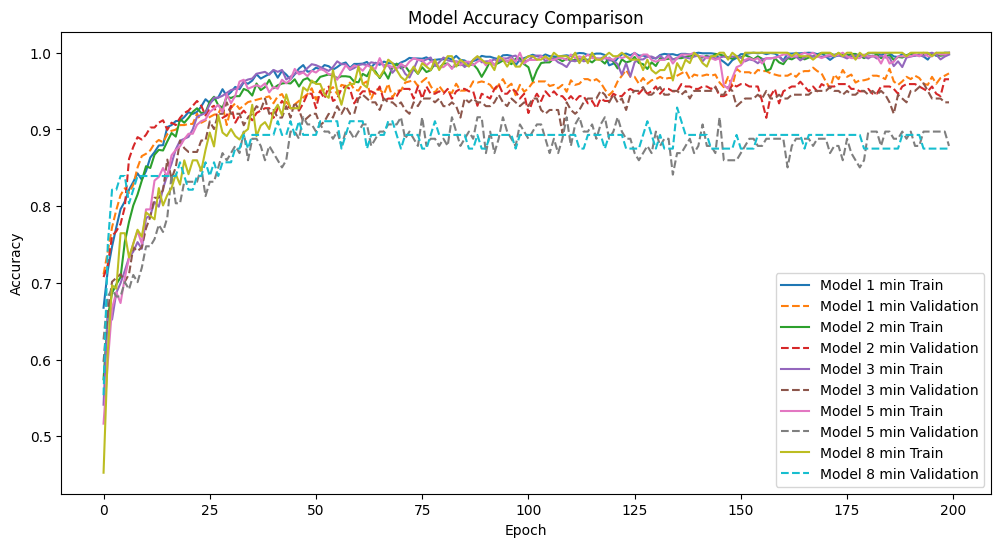

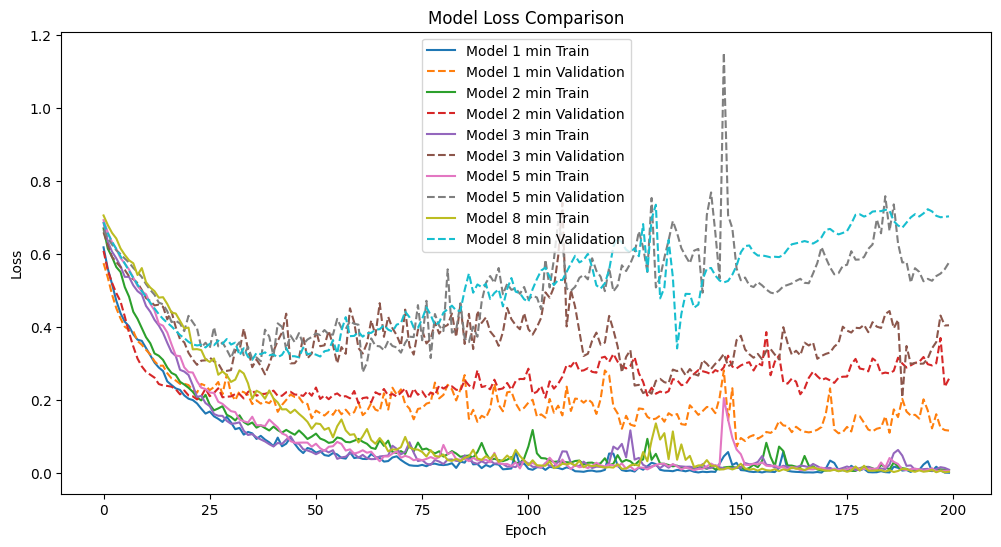

In [17]:
# all histories and model 
histories = [history_1_min, history_2_min, history_3_min, history_5_min, history_8_min]
model_names = ['Model 1 min', 'Model 2 min', 'Model 3 min', 'Model 5 min', 'Model 8 min']

# plot accuracy for all models
plt.figure(figsize=(12, 6))
for history, name in zip(histories, model_names):
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation', linestyle='--')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# plot loss for all models
plt.figure(figsize=(12, 6))
for history, name in zip(histories, model_names):
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Validation', linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## Models Predictions

### ROC Curve

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final Test Predictions Results for Model 1 min:
  Accuracy: 0.959
  Precision: 0.951
  Recall: 0.969
  F1 Score: 0.960
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Final Test Predictions Results for Model 2 min:
  Accuracy: 0.945
  Precision: 0.955
  Recall: 0.937
  F1 Score: 0.946
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Final Test Predictions Results for Model 3 min:
  Accuracy: 0.896
  Precision: 0.872
  Recall: 0.928
  F1 Score: 0.899
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Final Test Predictions Results for Model 5 min:
  Accuracy: 0.888
  Precision: 0.938
  Recall: 0.847
  F1 Score: 0.891
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Final Test Predictions Results for Model 8 min:
  Accuracy: 0.786
  Precision: 0.769
  Recall: 0.833
  F1 Score: 0.800


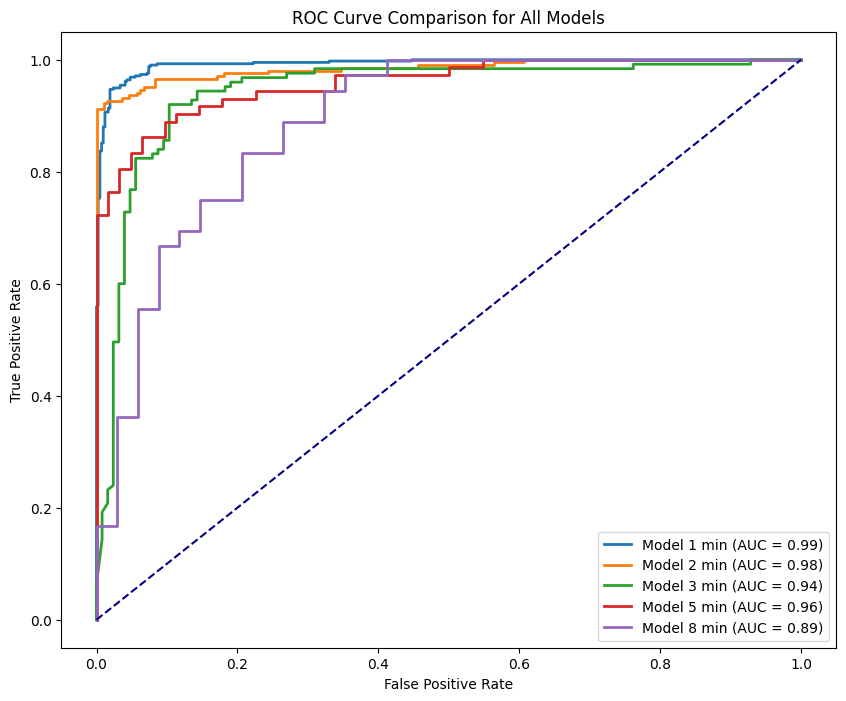

In [18]:
# models, test data, and names
models = [model_1_min, model_2_min, model_3_min, model_5_min, model_8_min]
X_tests = [X_test_1_min, X_test_2_min, X_test_3_min, X_test_5_min, X_test_8_min]
y_tests = [y_test_1_min, y_test_2_min, y_test_3_min, y_test_5_min, y_test_8_min]
model_names = ['Model 1 min', 'Model 2 min', 'Model 3 min', 'Model 5 min', 'Model 8 min']

# store results
all_metrics = []

# ROC plot setup
plt.figure(figsize=(10, 8))

for model, X_test, y_test, name in zip(models, X_tests, y_tests, model_names):
    # make predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)  # threshold and reshape to binary

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    # append metrics results
    all_metrics.append((name, accuracy, precision, recall, f1))
    
    # print results for the model
    print(f"Final Test Predictions Results for {name}:")
    print(f'  Accuracy: {accuracy:.3f}')
    print(f'  Precision: {precision:.3f}')
    print(f'  Recall: {recall:.3f}')
    print(f'  F1 Score: {f1:.3f}')
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# plot all ROC curves together
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for All Models')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


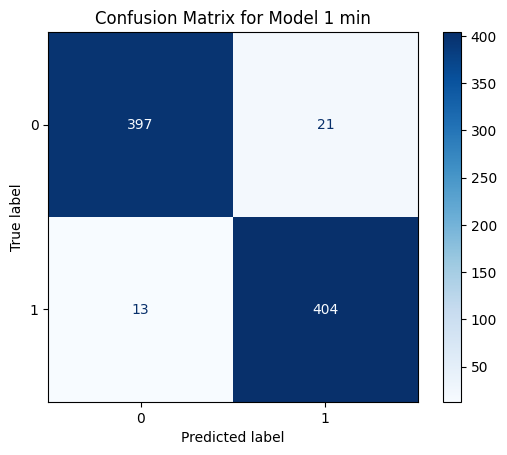

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


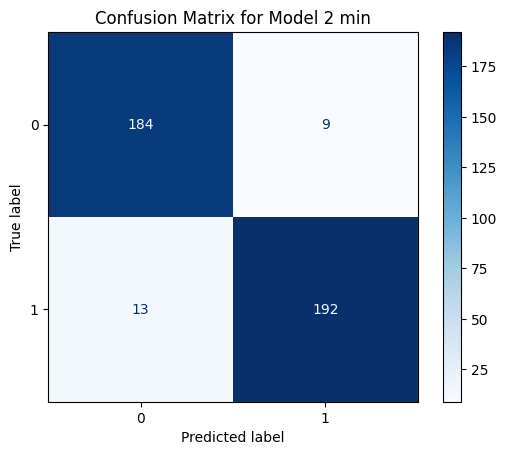

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


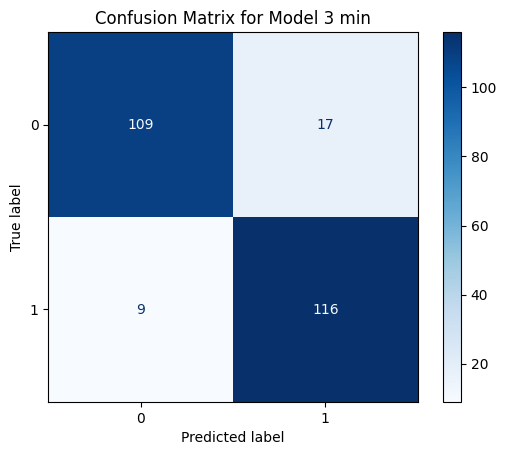

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


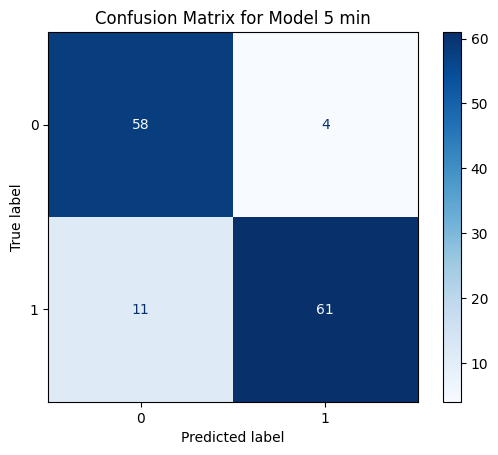

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


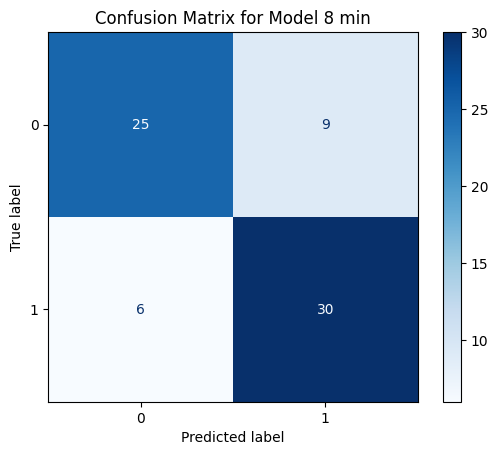

In [19]:
# CM
for model, X_test, y_test, name in zip(models, X_tests, y_tests, model_names):
    y_pred_binary = (model.predict(X_test) > 0.5).astype(int).reshape(-1)
    cm = confusion_matrix(y_test, y_pred_binary)
    
    # plot CM
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

### Evaluation Resume


Summary of Evaluation Metrics for All Models:
Model 1 min: Accuracy=0.959, Precision=0.951, Recall=0.969, F1 Score=0.960
Model 2 min: Accuracy=0.945, Precision=0.955, Recall=0.937, F1 Score=0.946
Model 3 min: Accuracy=0.896, Precision=0.872, Recall=0.928, F1 Score=0.899
Model 5 min: Accuracy=0.888, Precision=0.938, Recall=0.847, F1 Score=0.891
Model 8 min: Accuracy=0.786, Precision=0.769, Recall=0.833, F1 Score=0.800


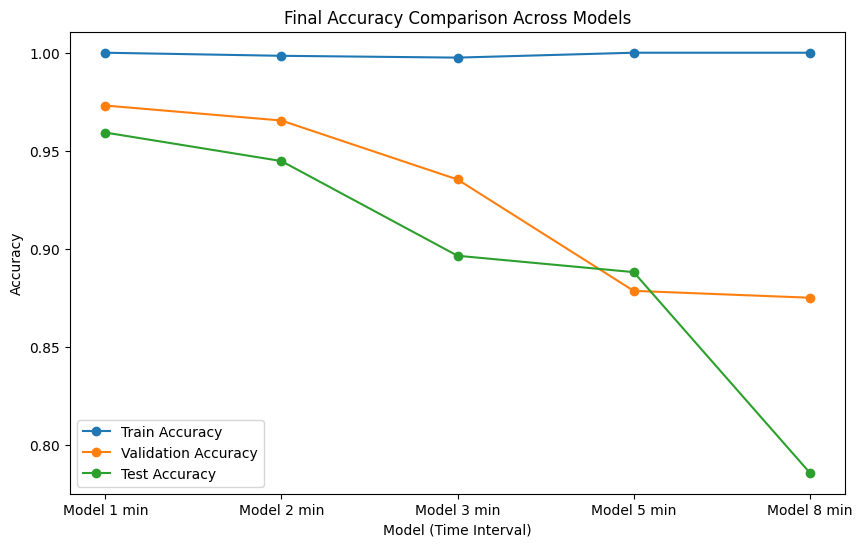

In [ ]:
# models evaluation
print("\nSummary of Evaluation Metrics for All Models:")
for name, accuracy, precision, recall, f1 in all_metrics:
    print(f'{name}: Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1 Score={f1:.3f}')


# training and validation accuracies for each model
final_train_accuracies = [history.history['accuracy'][-1] for history in histories]
final_val_accuracies = [history.history['val_accuracy'][-1] for history in histories]

# Extract test accuracies from all_metrics
final_test_accuracies = [metric[1] for metric in all_metrics]  # accuracy is the second element in each tuple in all_metrics

# plot all accuracies
plt.figure(figsize=(10, 6))
plt.plot(model_names, final_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(model_names, final_val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(model_names, final_test_accuracies, marker='o', label='Test Accuracy')
plt.title('Final Accuracy Comparison Across Models')
plt.xlabel('Model (Time Interval)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()